In [200]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
from pydub import AudioSegment

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

from keras import backend as K

import numpy as np
import os
import random
import sys
import io
import glob
import IPython
import warnings
warnings.filterwarnings('ignore')

In [204]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [41]:
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

In [42]:
def match_target_amplitude(sound, target_dBFS):
    change_in_dBFS = target_dBFS - sound.dBFS
    return sound.apply_gain(change_in_dBFS)

In [39]:
def load_raw_audio():
    activates = []
    backgrounds = []
    negatives = []
    for filename in os.listdir("./raw_data/activates"):
        if filename.endswith("wav"):
            activate = AudioSegment.from_wav("./raw_data/activates/"+filename)
            activates.append(activate)
    for filename in os.listdir("./raw_data/backgrounds"):
        if filename.endswith("wav"):
            background = AudioSegment.from_wav("./raw_data/backgrounds/"+filename)
            backgrounds.append(background)
    for filename in os.listdir("./raw_data/negatives"):
        if filename.endswith("wav"):
            negative = AudioSegment.from_wav("./raw_data/negatives/"+filename)
            negatives.append(negative)
    return activates, negatives, backgrounds

In [43]:
Tx = 5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

activates, negatives, backgrounds = load_raw_audio()

In [44]:
def get_random_time_segment(segment_ms):
    
    segment_start = np.random.randint(low=0, high=10000-segment_ms) 
    segment_end = segment_start + segment_ms - 1
    
    return (segment_start, segment_end)

In [45]:
def is_overlapping(segment_time, previous_segments):
    
    segment_start, segment_end = segment_time
    overlap = False
    
    for previous_start, previous_end in previous_segments:
        if not (segment_end<previous_start or segment_start>previous_end):
            overlap = True
    
    return overlap

In [46]:
def insert_audio_clip(background, audio_clip, previous_segments):
    
    segment_ms = len(audio_clip)
    segment_time = get_random_time_segment(segment_ms)
    
    while is_overlapping(segment_time,previous_segments):
        segment_time = get_random_time_segment(segment_ms)

    previous_segments.append(segment_time)
    
    new_background = background.overlay(audio_clip, position = segment_time[0])
    
    return new_background, segment_time

In [47]:
def insert_ones(y, segment_end_ms):
    
    # duration of the background (in terms of spectrogram time-steps)
    segment_end_y = int(segment_end_ms * Ty / 10000.0)
    
    for i in range(segment_end_y+1, min(y.shape[1],segment_end_y+51)):
        y[0, i] = 1
    
    return y

In [60]:
def create_training_example(background, activates, negatives):
    
    # Make background quieter
    background = background - 20

    y = np.zeros((1,Ty))

    previous_segments = []
    
    number_of_activates = np.random.randint(0, 5)
    random_indices = np.random.randint(len(activates), size=number_of_activates)
    random_activates = [activates[i] for i in random_indices]

    for random_activate in random_activates:
        
        background, segment_time = insert_audio_clip(background,random_activate,previous_segments)
        segment_start, segment_end = segment_time
        y = insert_ones(y,segment_end)

    number_of_negatives = np.random.randint(0, 3)
    random_indices = np.random.randint(len(negatives), size=number_of_negatives)
    random_negatives = [negatives[i] for i in random_indices]

    for random_negative in random_negatives:
        background, _ = insert_audio_clip(background,random_negative,previous_segments)

    background = match_target_amplitude(background, -20.0)


    file_handle = background.export("train" + ".wav", format="wav")
    
    x = graph_spectrogram("train.wav")
    
    return x, y

In [104]:
# X=[]
# Y=[]

# for i in range(2):
#     idx = np.random.randint(len(backgrounds))
#     x,y=create_training_example(backgrounds[idx],activates,negatives)
#     X.append(x)
#     Y.append(y)
    
# X=np.asarray(X).swapaxes(2,1)
# Y=np.asarray(Y).swapaxes(2,1)

# print('{} sample audio synthesized'.format(X.shape[0]))

# np.save('train_set/X.npy',X)
# np.save('train_set/Y.npy',Y)

32 sample audio synthesized


In [ ]:
X = np.load('train_set/X.npy')
Y = np.load('train_set/Y.npy')

In [183]:
# X_dev=[]
# Y_dev=[]

# for i in range(1):
#     idx = np.random.randint(len(backgrounds))
#     x,y=create_training_example(backgrounds[idx],activates,negatives)
#     X_dev.append(x)
#     Y_dev.append(y)
    
# X_dev=np.asarray(X_dev).swapaxes(2,1)
# Y_dev=np.asarray(Y_dev).swapaxes(2,1)

# print('{} sample audio synthesized for dev set'.format(X_dev.shape[0]))

# np.save('dev_set/X_dev.npy',X_dev)
# np.save('dev_set/Y_dev.npy',Y_dev)

20 sample audio synthesized for dev set


In [ ]:
X_dev = np.load('dev_set/X_dev.npy')
Y_dev = np.load('dev_set/Y_dev.npy')

# Model Building

In [76]:
def model(input_shape):

    X_input = Input(shape = input_shape)
    

    X = Conv1D(filters=196,kernel_size=15,strides=4)(X_input)  
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    X = Dropout(0.8)(X)


    X = GRU(units=128,return_sequences=True)(X)
    X = Dropout(0.8)(X)
    X = BatchNormalization()(X)
    
    
    X = GRU(units=128,return_sequences=True)(X)              
    X = Dropout(0.8)(X)                       
    X = BatchNormalization()(X)            
    X = Dropout(0.8)(X)                    
    
    
    X = TimeDistributed(Dense(1,activation='sigmoid'))(X) # time distributed (Dense layer shares weights learned)


    model = Model(inputs = X_input, outputs = X)
    
    return model

In [77]:
model = model(input_shape = (Tx, n_freq))

In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 5511, 101)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1375, 196)         297136    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1375, 196)         784       
_________________________________________________________________
activation_2 (Activation)    (None, 1375, 196)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 1375, 196)         0         
_________________________________________________________________
gru_3 (GRU)                  (None, 1375, 128)         124800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1375, 128)         0         
__________

In [196]:
model = load_model('./models/tr_model.h5')

In [205]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_score])
model.fit(X, Y, batch_size = 5, epochs=10)

Epoch 1/10
32/32 [==============================] - 12s 373ms/step - loss: 0.2014 - f1_score: 0.4593
Epoch 2/10
32/32 [==============================] - 9s 280ms/step - loss: 0.1807 - f1_score: 0.5218
Epoch 3/10
32/32 [==============================] - 9s 278ms/step - loss: 0.1882 - f1_score: 0.5160
Epoch 4/10
32/32 [==============================] - 9s 277ms/step - loss: 0.1723 - f1_score: 0.4809
Epoch 5/10
32/32 [==============================] - 9s 280ms/step - loss: 0.1581 - f1_score: 0.5323
Epoch 6/10
32/32 [==============================] - 10s 297ms/step - loss: 0.1549 - f1_score: 0.5536
Epoch 7/10
32/32 [==============================] - 9s 278ms/step - loss: 0.1466 - f1_score: 0.5607
Epoch 8/10
32/32 [==============================] - 9s 285ms/step - loss: 0.1340 - f1_score: 0.5932
Epoch 9/10
32/32 [==============================] - 11s 335ms/step - loss: 0.1564 - f1_score: 0.5435
Epoch 10/10
32/32 [==============================] - 11s 330ms/step - loss: 0.1163 - f1_score: 0.

In [187]:
loss, acc = model.evaluate(X_dev, Y_dev)
print("Dev set accuracy = ", acc)

20/20 [==============================] - 1s 43ms/step
Dev set accuracy =  0.9356363415718079


In [189]:
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectrogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    
    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()
    return predictions

In [190]:
chime_file = "audio_examples/chime.wav"
def chime_on_activate(filename, predictions, threshold):
    audio_clip = AudioSegment.from_wav(filename)
    chime = AudioSegment.from_wav(chime_file)
    Ty = predictions.shape[1]

    consecutive_timesteps = 0

    for i in range(Ty):

        consecutive_timesteps += 1
        #If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            #Superpose audio and background using pydub
            audio_clip = audio_clip.overlay(chime, position = ((i / Ty) * audio_clip.duration_seconds)*1000)
            #Reset consecutive output steps to 0
            consecutive_timesteps = 0
        
    audio_clip.export("chime_output.wav", format='wav')

In [74]:
IPython.display.Audio("./raw_data/dev/1.wav")

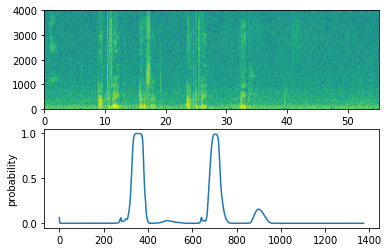

In [197]:
filename = "./raw_data/dev/2.wav"
prediction = detect_triggerword(filename)
chime_on_activate(filename, prediction, 0.5)
IPython.display.Audio("./chime_output.wav")

In [ ]:
# Preprocess the audio to the correct format
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')

In [ ]:
your_filename = "audio_examples/my_audio.wav"

In [ ]:
preprocess_audio(your_filename)
IPython.display.Audio(your_filename) # listen to the audio you uploaded 

In [ ]:
chime_threshold = 0.5
prediction = detect_triggerword(your_filename)
chime_on_activate(your_filename, prediction, chime_threshold)
IPython.display.Audio("./chime_output.wav")